In [776]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer ,ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
import re 
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# 1- Make a data set with all emotions



### Merge The two datasets to get neutral emotion 

In [777]:
df1 = pd.read_csv('./First_Dataset/training.csv')
df1.shape

(16108, 2)

In [778]:
df3 = pd.read_csv('./Second_Dataset/tweet_emotions.csv')
df3.shape

(40000, 3)

In [779]:
df3 = df3[df3.sentiment == 'neutral'] 

df3.shape

(8638, 3)

In [780]:
df3=df3[:200]
df3.shape

(200, 3)

In [781]:
df3.head()

,tweet_id,sentiment,content
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
10,1956969456,neutral,cant fall asleep
22,1956972116,neutral,No Topic Maps talks at the Balisage Markup Con...
31,1956975441,neutral,@cynthia_123 i cant sleep
32,1956975860,neutral,I missed the bl***y bus!!!!!!!!


### Drop the id column

In [782]:
df3.drop(['tweet_id'],axis=1,inplace = True)

In [783]:
df3.head()

,sentiment,content
4,neutral,@dannycastillo We want to trade with someone w...
10,neutral,cant fall asleep
22,neutral,No Topic Maps talks at the Balisage Markup Con...
31,neutral,@cynthia_123 i cant sleep
32,neutral,I missed the bl***y bus!!!!!!!!


### Rename the coulmns names


In [784]:
df3.rename(
    columns={"sentiment":"label",
                "content":"text",
                   }
          ,inplace=True)
df3.head()

,label,text
4,neutral,@dannycastillo We want to trade with someone w...
10,neutral,cant fall asleep
22,neutral,No Topic Maps talks at the Balisage Markup Con...
31,neutral,@cynthia_123 i cant sleep
32,neutral,I missed the bl***y bus!!!!!!!!


### insert value 6 insted of neutral word

In [785]:
df3.label =int(6) 
df3.head()

,label,text
4,6,@dannycastillo We want to trade with someone w...
10,6,cant fall asleep
22,6,No Topic Maps talks at the Balisage Markup Con...
31,6,@cynthia_123 i cant sleep
32,6,I missed the bl***y bus!!!!!!!!


### Concat the two datasets

In [786]:
df = pd.concat([df1, df3], ignore_index = True, axis = 0)
df.shape

(16308, 2)

### shuffle the data set 

In [787]:
df=df.sample(frac = 1)

In [788]:
df.head()
#label_dict = {0:'sad', 1:'happy', 2:'love', 3:'angry', 4:'fear', 5:'surprise',6:'neutral'}


,text,label
2751,i feel its rude to take someone s photo but ra...,3
8637,i was cut into feeling pain that shocked me,5
9497,i am thinking and keeping current so they don ...,1
11880,i feel distracted and its sometimes hard to ta...,3
14758,i felt like i had went so far now it feels lik...,4


### drop the fear and surprise emotions

In [789]:
df = df[df.label != 4] #& 'boredom' & 'enthusiasm' & 'empty'
df = df[df.label != 5]

df = df[df.label != 'sentiment']
df.head()

,text,label
2751,i feel its rude to take someone s photo but ra...,3
9497,i am thinking and keeping current so they don ...,1
11880,i feel distracted and its sometimes hard to ta...,3
8179,i feel like crap for being ungrateful,0
11184,i feel like i am getting fucked,3


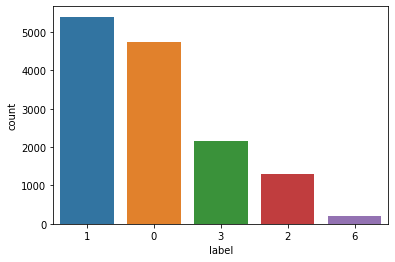

In [790]:
#label_dict = {0:'sad', 1:'happy', 2:'love', 3:'angry',6:'neutral'}

sns.countplot(df['label'],order = df['label'].value_counts(normalize=True).index)

# Data Preprocessing

1- clean any HTML tags in the text

In [791]:
def clean_html(text):
    
    clean = re.compile('<.*?>')
    return re.sub(clean, '',text)
    
df['text']=df['text'].apply(clean_html)
df.head()

,text,label
2751,i feel its rude to take someone s photo but ra...,3
9497,i am thinking and keeping current so they don ...,1
11880,i feel distracted and its sometimes hard to ta...,3
8179,i feel like crap for being ungrateful,0
11184,i feel like i am getting fucked,3


2- convert all the text into lower case 

In [792]:
def convert_lower(text):
    return text.lower()

df['text']=df['text'].apply(convert_lower)
df.head()

,text,label
2751,i feel its rude to take someone s photo but ra...,3
9497,i am thinking and keeping current so they don ...,1
11880,i feel distracted and its sometimes hard to ta...,3
8179,i feel like crap for being ungrateful,0
11184,i feel like i am getting fucked,3


3- clean the Tag sign and Tag name (ex:@Paula)

In [793]:
def cleaning_tags(text):
    return ' '.join(re.sub("([@#][A-Za-z0-9_]+)|(\w+:\/\/\S+)"," ", text).split())

df['text'] = df['text'].apply(lambda x: cleaning_tags(x))
df['text'].head()

2751     i feel its rude to take someone s photo but ra...
9497     i am thinking and keeping current so they don ...
11880    i feel distracted and its sometimes hard to ta...
8179                 i feel like crap for being ungrateful
11184                      i feel like i am getting fucked
Name: text, dtype: object

4- clean all the punctuations  

In [794]:

english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
df['text']= df['text'].apply(lambda x: cleaning_punctuations(x))
df['text'].head()

2751     i feel its rude to take someone s photo but ra...
9497     i am thinking and keeping current so they don ...
11880    i feel distracted and its sometimes hard to ta...
8179                 i feel like crap for being ungrateful
11184                      i feel like i am getting fucked
Name: text, dtype: object

In [795]:
#def cleaning_repeating_char(text):
 #   return re.sub(r'([a-z])\1+', r'\1', text)
#df['text'] = df['text'].apply(lambda x: cleaning_repeating_char(x))
#df['text'].head()

5- clean the urls founded in the tweets


In [796]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
df['text'] = df['text'].apply(lambda x: cleaning_URLs(x))
df['text'].head()

2751     i feel its rude to take someone s photo but ra...
9497     i am thinking and keeping current so they don ...
11880    i feel distracted and its sometimes hard to ta...
8179                 i feel like crap for being ungrateful
11184                      i feel like i am getting fucked
Name: text, dtype: object

6- clean all numbers 

In [797]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
df['text'] = df['text'].apply(lambda x: cleaning_numbers(x))
df['text'].head()

2751     i feel its rude to take someone s photo but ra...
9497     i am thinking and keeping current so they don ...
11880    i feel distracted and its sometimes hard to ta...
8179                 i feel like crap for being ungrateful
11184                      i feel like i am getting fucked
Name: text, dtype: object

7-remove stopwords from data

In [798]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df.head()

[nltk_data] Downloading package stopwords to /home/paula/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label
2751,feel rude take someone photo rather feel awkwa...,3
9497,thinking keeping current feel need keep entert...,1
11880,feel distracted sometimes hard talk god used s...,3
8179,feel like crap ungrateful,0
11184,feel like getting fucked,3


8- stemming words in data

In [799]:
from nltk.stem.porter import PorterStemmer
ps= PorterStemmer()
y=[]

def stem_words(text):
    for i in text:
        y.append(ps.stem(i))
    z=y[:]
    y.clear()
    return z
df['text']=df['text'].apply(stem_words)
df.head()

,text,label
2751,"[f, e, e, l, , r, u, d, e, , t, a, k, e, , ...",3
9497,"[t, h, i, n, k, i, n, g, , k, e, e, p, i, n, ...",1
11880,"[f, e, e, l, , d, i, s, t, r, a, c, t, e, d, ...",3
8179,"[f, e, e, l, , l, i, k, e, , c, r, a, p, , ...",0
11184,"[f, e, e, l, , l, i, k, e, , g, e, t, t, i, ...",3


9- join back after stemming

In [800]:
def joinback2(list_input):
    return "".join(list_input)
    


df['text']=df['text'].apply(joinback2)
df.head()



,text,label
2751,feel rude take someone photo rather feel awkwa...,3
9497,thinking keeping current feel need keep entert...,1
11880,feel distracted sometimes hard talk god used s...,3
8179,feel like crap ungrateful,0
11184,feel like getting fucked,3


### Exploratory data analysis 

1- Sad Emotion

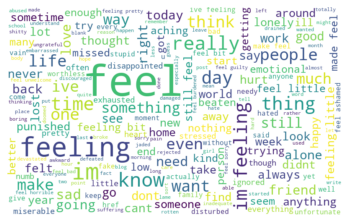

In [801]:
txt = ' '.join(text for text in df[df['label']==0]['text'])

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 200,
            width = 800,
            height = 500
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

2- Happy Emotion

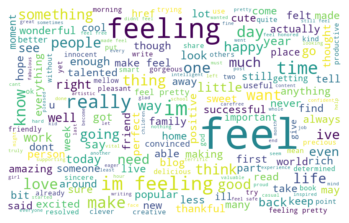

In [802]:
txt = ' '.join(text for text in df[df['label']==1]['text'])

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 200,
            width = 800,
            height = 500
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

3- Love Emotion

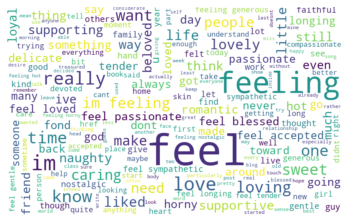

In [803]:
txt = ' '.join(text for text in df[df['label']==2]['text'])

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 200,
            width = 800,
            height = 500
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

4-Angry Emotion

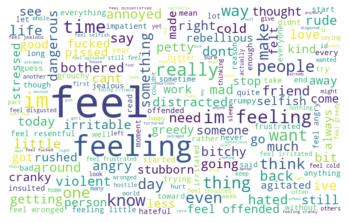

In [804]:
txt = ' '.join(text for text in df[df['label']==3]['text'])

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 200,
            width = 800,
            height = 500
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

5- Neutral Emotion

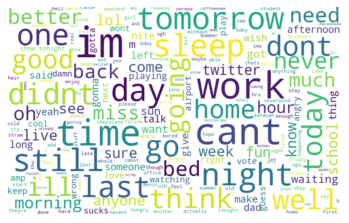

In [805]:
txt = ' '.join(text for text in df[df['label']==6]['text'])

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 200,
            width = 800,
            height = 500
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

### split data 

In [806]:
X=df['text']
y=df.label
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.3) 

### Transfer data into numerical features using TFIDF

In [807]:

import pickle
vec = TfidfVectorizer(binary=True, use_idf=True, ngram_range=(1,2))
tf_model = vec.fit(X_train)
X_train = vec.fit_transform(X_train) 
X_test = vec.transform(X_test)


In [808]:
#pickle.dump(X_train, open("./First_Dataset/tfidf1.pkl", "wb"))
#pickle.dump(X_test, open("./First_Dataset/tfidf2.pkl", "wb"))
#pickle.dump(tf_model, open("./First_Dataset/tfidf3.pkl", "wb"))

In [809]:
print(vec)

TfidfVectorizer(binary=True, ngram_range=(1, 2))


In [810]:
X_test.shape

(4140, 71366)

### Try first model passive aggressive classfier

In [811]:
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(X_train,y_train)

PassiveAggressiveClassifier(max_iter=50)

In [812]:
y_pred=pac.predict(X_test)
score=accuracy_score(y_test,y_pred)
print(f'PassiveAggressiveClassifier Accuracy: {round(score*100,2)}%')


PassiveAggressiveClassifier Accuracy: 91.88%


### Try second model : logistic regression

In [813]:
log_reg = LogisticRegression(max_iter=50).fit(X_train, y_train)


/home/paula/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [814]:
y_predicted = log_reg.predict(X_test)
score=accuracy_score(y_test,y_predicted)
print(f'LogisticRegression Accuracy: {round(score*100,2)}%')

LogisticRegression Accuracy: 87.42%


### Try third model : xgboost 

In [815]:
model = XGBClassifier(use_label_encoder=True, eval_metric='mlogloss', n_estimators=100,learning_rate=0.2)

In [816]:
model.fit(X_train, y_train)


[18:12:12] WARNING: /workspace/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [817]:
y_pred = model.predict(X_test)
score=accuracy_score(y_test,y_pred)
print(f'XGBClassifier Accuracy: {round(score*100,2)}%')

XGBClassifier Accuracy: 90.0%


### Testing

In [775]:

Lines=["i'm  sad" ]

#Lines=Lines.lower()
print (Lines)
#Lines = cv.transform(Lines)
Lines =vec.transform(Lines)
scores = pac.predict(Lines)  
#Prob score for both classes (Good/bad) 
score = scores[0]
print(score)



["i'm  sad"]
0


In [818]:
import joblib as joblib
filename = './First_Dataset/finalized_model.sav'
joblib.dump(pac, filename)



#pac.save_model("./First Data/ best_classicalmodel.json")


['./First_Dataset/finalized_model.sav']